# Assignment 9: GBDT

#### Response Coding: Example

<img src='http://i.imgur.com/TufZptV.jpg' width=700px>

> The response tabel is built only on train dataset.
> For a category which is not there in train data and present in test data, we will encode them with default values
Ex: in our test data if have State: D then we encode it as [0.5, 0.05]

<ol>
    <li><strong>Apply GBDT on these feature sets</strong>
        <ul>
            <li><font color='red'>Set 1</font>: categorical(instead of one hot encoding, try <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/'>response coding</a>: use probability values), numerical features + project_title(TFIDF)+  preprocessed_eassay (TFIDF)+sentiment Score of eassay(check the bellow example, include all 4 values as 4 features)</li>
            <li><font color='red'>Set 2</font>: categorical(instead of one hot encoding, try <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/'>response coding</a>: use probability values), numerical features + project_title(TFIDF W2V)+  preprocessed_eassay (TFIDF W2V)</li>        
    </li>
    <li> Here in response encoding you need to apply the <strong>laplase smoothing</strong> value for test set. Laplase smoothing means, If test point is present in test but not in train then you need to apply default 0.5 as probability value for that data point (Refer the Response Encoding Image from above cell) </li>
    <li>Please use atleast <strong> 35k </strong> data points </li></ul>
    <li><strong>The hyper paramter tuning (Consider any two hyper parameters)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>find the best hyper paramter using k-fold cross validation/simple cross validation data</li>
    <li>use gridsearch cv or randomsearch cv or you can write your own for loops to do this task</li>
        </ul>
    </li>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/Gp2DQmh.jpg' width=500px> with X-axis as <strong>n_estimators</strong>, Y-axis as <strong>max_depth</strong>, and Z-axis as <strong>AUC Score</strong> , we have given the notebook which explains how to plot this 3d plot, you can find it in the same drive <i>3d_scatter_plot.ipynb</i></li>
            <p style="text-align:center;font-size:30px;color:red;"><strong>or</strong></p> <br>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/fgN9aUP.jpg' width=300px> <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heat maps</a> with rows as <strong>n_estimators</strong>, columns as <strong>max_depth</strong>, and values inside the cell representing <strong>AUC Score</strong> </li>
    <li>You choose either of the plotting techniques out of 3d plot or heat map</li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
        Make sure that you are using predict_proba method to calculate AUC curves, because AUC is calcualted on class probabilities and not on class labels.
    <img src='https://i.imgur.com/wMQDTFe.jpg' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='https://i.imgur.com/IdN5Ctv.png' width=300px></li>
            </ul>
    <br>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format
        <img src='http://i.imgur.com/YVpIGGE.jpg' width=400px>
    </li>
</ol>

# Few Notes

1. Use atleast 35k data points
2. Use classifier.Predict_proba() method instead of predict() method while calculating roc_auc scores
3. Be sure that you are using laplase smoothing in response encoding function. Laplase smoothing means applying the default (0.5) value to test data if the test data is not present in the train set


In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/

import pickle
from tqdm import tqdm
import os

from collections import Counter
import math

In [2]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [3]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

sample_sentence_1='I am happy.'
ss_1 = sid.polarity_scores(sample_sentence_1)
print('sentiment score for sentence 1',ss_1)

sample_sentence_2='I am sad.'
ss_2 = sid.polarity_scores(sample_sentence_2)
print('sentiment score for sentence 2',ss_2)

sample_sentence_3='I am going to New Delhi tommorow.'
ss_3 = sid.polarity_scores(sample_sentence_3)
print('sentiment score for sentence 3',ss_3)


sentiment score for sentence 1 {'neg': 0.0, 'neu': 0.213, 'pos': 0.787, 'compound': 0.5719}
sentiment score for sentence 2 {'neg': 0.756, 'neu': 0.244, 'pos': 0.0, 'compound': -0.4767}
sentiment score for sentence 3 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}


<h1>1. GBDT (xgboost/lightgbm) </h1>

## 1.1 Loading Data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import pandas
data = pandas.read_csv('/content/drive/MyDrive/Case Studies/Donor Choose/6_Donors_choose_NB/preprocessed_data.csv',nrows = 35000)

In [6]:
print(data.shape)

data.head(2)

(35000, 9)


,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03


In [7]:
def get_sentiment_scores(sentence):

  sid = SentimentIntensityAnalyzer()

  sentiment_score = []

  scores = sid.polarity_scores(sentence)
  
  sentiment_score.append(scores['neg'])
  sentiment_score.append(scores['neu'])
  sentiment_score.append(scores['pos'])
  sentiment_score.append(scores['compound'])
  
  return sentiment_score

In [8]:
%%time 

score_list = []

# it will take around 7 min to get the score of 35k points 
scores     = data.apply(lambda x:get_sentiment_scores(x["essay"]), axis = 1)

CPU times: user 5min 56s, sys: 1.63 s, total: 5min 58s
Wall time: 6min 29s


In [9]:
for lists in tqdm(scores):
  score_list.append(lists)

df = pd.DataFrame(score_list)
df.columns = ['negative','neutral','positive','compound']

frames = [data,df]

# https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html 

final_data = pd.concat(frames,axis = 1)

print(final_data.shape)
final_data.head(2)

100%|██████████| 35000/35000 [00:00<00:00, 1500906.27it/s]

(35000, 13)


,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price,negative,neutral,positive,compound
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05,0.013,0.783,0.205,0.9867
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03,0.072,0.680,0.248,0.9897


In [10]:
# 2. Split your data.

y = final_data['project_is_approved'].values

X = final_data.drop(['project_is_approved'], axis = 1)

print(y.shape,X.shape)
print(final_data.shape[1] - X.shape[1])

X.head(2)

(35000,) (35000, 12)
1


,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories,essay,price,negative,neutral,positive,compound
0,ca,mrs,grades_prek_2,53,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05,0.013,0.783,0.205,0.9867
1,ut,ms,grades_3_5,4,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03,0.072,0.680,0.248,0.9897


<h2>1.2 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, stratify = y)

<h2> Make Data Model Ready: encoding numerical, categorical features</h2>

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range = (1, 3),max_features = 6000, min_df = 10)

vectorizer.fit(X_train['essay'].values)

X_train_essay_tfidf = vectorizer.transform(X_train['essay'].values)
X_test_essay_tfidf  = vectorizer.transform(X_test['essay'].values)

# we are converting a dictionary with word as a key, and the idf as a value

dictionary  = dict(zip(vectorizer.get_feature_names(), list(vectorizer.idf_)))
tfidf_words = set(dictionary.keys())

vectorizer.get_feature_names()[-5:]

['your donations', 'your generous', 'your generous donation', 'youth', 'zone']

In [13]:
def get_response_coding(feature,labels,dx,test = False):

  positive_label = [] 
  negative_label = []

  frame = pd.DataFrame({'feature_name':feature,'label':labels})
  # print( frame.head(3) )

  if test == False:

    total_size = frame.shape[0]
    dx = dict() # Initializing a dictionary that would hold the unique values of categorical features

    for data in frame['feature_name']:
  
      if data not in dx:
        dx[data] = 0

    print(" **---** Response Encoding the Test data **---** ")
    # so now we have all the unique values of feature stored in our dictionary dx, now we will store prob value inside it.

    for key,value in dx.items():

      positive_class = frame[( frame['feature_name'] == key ) & (frame['label'] == 1) ] 

      dx[key] = positive_class.shape[0] / total_size

    for data in frame['feature_name']:
    
      positive_label.append(dx[data])
      negative_label.append(1 - dx[data])
  
    print("\n Shape of the provided train data datframe is  ->",frame.shape[0])
    print("\n len of positive encoded feature of train data ->",len(positive_label))
    print("\n len of negative encoded feature of train data ->",len(negative_label),"\n")

    return [positive_label,negative_label,dx]

  else:
    
    print(" \n**---** Response Encoding the Test data **---** ")

    for data in frame['feature_name']:
      
      try:

        positive_label.append(dx[data])
        negative_label.append(1 - dx[data])
      
      except:

        positive_label.append(0.5) # if there are entries that were not present in the train data those won't be inside the dictionary
        negative_label.append(0.5) # hence assigining them equal probabililty of 0.5. This is also called laplace smoothing.

    print("\n Shape of  the provide     Test dataframe  is ->",frame.shape[0])
    print("\n len of positive encoded feature of test data ->",len(positive_label))
    print("\n len of negative encoded feature of test data ->",len(negative_label))

    return [positive_label,negative_label]

**teacher_prefix**

In [14]:
teacher_prefix_pos,teacher_prefix_neg,teacher_prefix_dict = get_response_coding(X_train['teacher_prefix'].values,y_train,
                                                                                dict(),False)
print("Teacher_prefix_dict --",teacher_prefix_dict)

teacher_prefix_pos_te,teacher_prefix_neg_te = get_response_coding(X_test['teacher_prefix'].values,y_test,
                                                            teacher_prefix_dict,True)

 **---** Response Encoding the Test data **---** 

 Shape of the provided train data datframe is  -> 23450

 len of positive encoded feature of train data -> 23450

 len of negative encoded feature of train data -> 23450 

Teacher_prefix_dict -- {'ms': 0.29880597014925375, 'mrs': 0.46038379530916845, 'mr': 0.07125799573560768, 'teacher': 0.01603411513859275, 'dr': 4.2643923240938166e-05}
 
**---** Response Encoding the Test data **---** 

 Shape of  the provide     Test dataframe  is -> 11550

 len of positive encoded feature of test data -> 11550

 len of negative encoded feature of test data -> 11550


**project_grade**

In [15]:
project_grade_pos,project_grade_neg,project_grade_dict = get_response_coding(X_train['project_grade_category'].values,y_train,
                                                                                dict(),False)

print(project_grade_dict)

project_grade_pos_te,project_grade_neg_te = get_response_coding(X_test['project_grade_category'].values,y_test,
                                                                                project_grade_dict,True)

 **---** Response Encoding the Test data **---** 

 Shape of the provided train data datframe is  -> 23450

 len of positive encoded feature of train data -> 23450

 len of negative encoded feature of train data -> 23450 

{'grades_prek_2': 0.36029850746268655, 'grades_6_8': 0.11884861407249467, 'grades_3_5': 0.289637526652452, 'grades_9_12': 0.07773987206823028}
 
**---** Response Encoding the Test data **---** 

 Shape of  the provide     Test dataframe  is -> 11550

 len of positive encoded feature of test data -> 11550

 len of negative encoded feature of test data -> 11550


**clean_categories**

In [16]:
clean_categories_pos,clean_categories_neg,clean_categories_dict = get_response_coding(X_train['clean_categories'].values,
                                                                            y_train,dict(),False)

print(clean_categories_dict)

clean_categories_pos_te,clean_categories_neg_te = get_response_coding(X_test['clean_categories'].values,y_test,
                                                                                clean_categories_dict,True)

 **---** Response Encoding the Test data **---** 

 Shape of the provided train data datframe is  -> 23450

 len of positive encoded feature of train data -> 23450

 len of negative encoded feature of train data -> 23450 

{'math_science': 0.11181236673773987, 'appliedlearning': 0.027547974413646054, 'health_sports': 0.1284008528784648, 'math_science history_civics': 0.005799573560767591, 'health_sports music_arts': 0.001279317697228145, 'literacy_language math_science': 0.11377398720682302, 'history_civics': 0.012750533049040511, 'music_arts': 0.03228144989339019, 'literacy_language': 0.18311300639658848, 'specialneeds': 0.024946695095948827, 'appliedlearning specialneeds': 0.010490405117270788, 'appliedlearning math_science': 0.0070362473347547975, 'literacy_language music_arts': 0.014371002132196163, 'math_science literacy_language': 0.01901918976545842, 'math_science specialneeds': 0.012238805970149255, 'literacy_language specialneeds': 0.028272921108742004, 'math_science music_art

**clean_subcategories**

In [17]:
clean_subcategories_pos,clean_subcategories_neg,clean_subcategories_dict = get_response_coding(X_train['clean_subcategories'].values,
                                                                            y_train,dict(),False)

print(clean_subcategories_dict)

clean_subcategories_pos_te,clean_subcategories_neg_te = get_response_coding(X_test['clean_subcategories'].values,y_test,
                                                                                clean_subcategories_dict,True)

 **---** Response Encoding the Test data **---** 

 Shape of the provided train data datframe is  -> 23450

 len of positive encoded feature of train data -> 23450

 len of negative encoded feature of train data -> 23450 

{'appliedsciences': 0.01420042643923241, 'charactereducation communityservice': 0.0005543710021321961, 'health_wellness': 0.051215351812366736, 'health_lifescience socialsciences': 0.0008102345415778252, 'health_wellness performingarts': 8.528784648187633e-05, 'literature_writing mathematics': 0.04844349680170576, 'mathematics': 0.03705756929637526, 'civics_government': 0.0006396588486140725, 'gym_fitness teamsports': 0.004093816631130064, 'gym_fitness health_wellness': 0.033347547974413645, 'music performingarts': 0.007249466950959489, 'literacy': 0.07253731343283581, 'specialneeds': 0.024946695095948827, 'appliedsciences mathematics': 0.023155650319829423, 'literacy literature_writing': 0.04660980810234541, 'earlydevelopment specialneeds': 0.0059275053304904055, 'e

**school_state**

In [18]:
school_state_pos,school_state_neg,school_state_dict = get_response_coding(X_train['school_state'].values,
                                                      y_train,dict(),False)

print(school_state_dict)

school_state_pos_te,school_state_neg_te = get_response_coding(X_test['school_state'].values,y_test,
                                                              school_state_dict,True)

 **---** Response Encoding the Test data **---** 

 Shape of the provided train data datframe is  -> 23450

 len of positive encoded feature of train data -> 23450

 len of negative encoded feature of train data -> 23450 

{'ga': 0.03121535181236674, 'wv': 0.004861407249466951, 'nj': 0.013859275053304905, 'wi': 0.012452025586353945, 'ar': 0.008315565031982943, 'ny': 0.05236673773987207, 'tx': 0.06098081023454158, 'dc': 0.004776119402985075, 'ca': 0.11381663113006396, 'oh': 0.02255863539445629, 'ms': 0.008827292110874201, 'il': 0.03484008528784648, 'in': 0.023582089552238807, 'md': 0.012707889125799574, 'mi': 0.024818763326226012, 'hi': 0.0028997867803837955, 'mn': 0.008528784648187633, 'sc': 0.03164179104477612, 'la': 0.012878464818763325, 'nm': 0.004392324093816631, 'mo': 0.0232409381663113, 'ks': 0.005031982942430704, 'pa': 0.024690831556503198, 'ak': 0.001833688699360341, 'fl': 0.05070362473347548, 'va': 0.016119402985074627, 'nc': 0.04494669509594883, 'ma': 0.01884861407249467, 'nv

**price**

In [19]:
## Price ##

from sklearn.preprocessing import StandardScaler

sc = StandardScaler(copy = True,with_mean = True,with_std = True)
sc.fit(X_train['price'].values.reshape(-1,1))

X_train_price_norm  =  sc.transform(X_train['price'].values.reshape(-1,1))
X_test_price_norm   =  sc.transform(X_test['price'].values.reshape(-1,1))

print("Mean--",sc.mean_)
print("std --",np.sqrt(sc.var_))

print(X_train_price_norm.shape)
print(X_train_price_norm.shape)

print(type(X_train_price_norm),X_train_price_norm[0])

Mean-- [302.38708273]
std -- [359.53218687]
(23450, 1)
(23450, 1)
<class 'numpy.ndarray'> [0.04587327]


**teacher_number_of_previously_posted_projects**

In [20]:
## teacher_number_of_previously_posted_projects ##

sc = StandardScaler(copy = True,with_mean = True,with_std = True)
sc.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

X_train_projects_posted_norm  =  sc.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_test_projects_posted_norm   =  sc.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

print("Mean--",sc.mean_)
print("std --",np.sqrt(sc.var_))

print(X_train_projects_posted_norm.shape)
print(X_train_projects_posted_norm.shape)

print(type(X_train_projects_posted_norm),X_train_projects_posted_norm[0])

Mean-- [9.89837953]
std -- [24.45583011]
(23450, 1)
(23450, 1)
<class 'numpy.ndarray'> [-0.3229651]


In [21]:
print(X_train_essay_tfidf.shape)
print(len(school_state_pos))


ps = np.array(school_state_pos)

print(ps.shape)
print(ps.reshape(-1,1).shape)

(23450, 6000)
23450
(23450,)
(23450, 1)


In [22]:
from scipy.sparse import  hstack

X_tr = hstack((
               X_train_essay_tfidf,
               np.array(school_state_pos).reshape(-1,1),np.array(school_state_neg).reshape(-1,1),
               np.array(project_grade_pos).reshape(-1,1),np.array(project_grade_neg).reshape(-1,1),
               np.array(clean_subcategories_pos).reshape(-1,1),np.array(clean_subcategories_neg).reshape(-1,1),
               np.array(clean_categories_pos).reshape(-1,1),np.array(clean_categories_neg).reshape(-1,1),
               X_train_price_norm,X_train_projects_posted_norm,
               X_train['negative'].values.reshape(-1,1),
               X_train['neutral'].values.reshape(-1,1),
               X_train['positive'].values.reshape(-1,1),
               X_train['compound'].values.reshape(-1,1)
               )).tocsr()

X_te = hstack((X_test_essay_tfidf,
               np.array(school_state_pos_te).reshape(-1,1),np.array(school_state_neg_te).reshape(-1,1),
               np.array(project_grade_pos_te).reshape(-1,1),np.array(project_grade_neg_te).reshape(-1,1),
               np.array(clean_subcategories_pos_te).reshape(-1,1),np.array(clean_subcategories_neg_te).reshape(-1,1),
               np.array(clean_categories_pos_te).reshape(-1,1),np.array(clean_categories_neg_te).reshape(-1,1),
               X_test_price_norm,X_test_projects_posted_norm,
               X_test['negative'].values.reshape(-1,1),
               X_test['neutral'].values.reshape(-1,1),
               X_test['positive'].values.reshape(-1,1),
               X_test['compound'].values.reshape(-1,1))).tocsr()

print("Final Data matrix")

print(X_tr.shape, y_train.shape)
print(X_te.shape, y_test.shape)

Final Data matrix
(23450, 6014) (23450,)
(11550, 6014) (11550,)


<h2>1.5 Appling Models on different kind of featurization as mentioned in the instructions</h2>

<br>Apply GBDT on different kind of featurization as mentioned in the instructions
<br> For Every model that you work on make sure you do the step 2 and step 3 of instrucations

**As the number of base models increase, variance tends to increase, bias
tends to decrease and leads to overfitting**

In [23]:
%%time 
# 2min 41s
# as the number of hyperparameters are large in this case so we will use randomized search cv insetad og gridsearch 

from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

gbdt = XGBClassifier(subsample = 0.5,colsample_bytree = 0.5)

grid_params = {'n_estimators': [10,30,50], 'max_depth':[2,5,7,9]}

clf = GridSearchCV(gbdt,grid_params ,cv = 2, scoring = 'roc_auc',n_jobs =-1,verbose = 2,return_train_score =  True)
clf.fit(X_tr, y_train)  

results = pd.DataFrame.from_dict(clf.cv_results_)

results.head(3)

Fitting 2 folds for each of 12 candidates, totalling 24 fits
CPU times: user 25.7 s, sys: 390 ms, total: 26.1 s
Wall time: 2min 41s


In [24]:
print( results.columns )

results.head()

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_max_depth', 'param_n_estimators', 'params', 'split0_test_score',
       'split1_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score', 'split0_train_score', 'split1_train_score',
       'mean_train_score', 'std_train_score'],
      dtype='object')


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,mean_train_score,std_train_score
0,2.821916,0.070690,1.056577,0.002813,2,10,"{'max_depth': 2, 'n_estimators': 10}",0.623033,0.655810,0.639422,0.016388,9,0.672918,0.675839,0.674379,0.001460
1,4.105777,0.030659,1.021959,0.005677,2,30,"{'max_depth': 2, 'n_estimators': 30}",0.645493,0.673732,0.659612,0.014119,8,0.708122,0.715746,0.711934,0.003812
2,5.972690,0.034490,1.018155,0.007849,2,50,"{'max_depth': 2, 'n_estimators': 50}",0.665560,0.688473,0.677016,0.011457,4,0.738818,0.745807,0.742312,0.003495
3,3.529773,0.008056,1.022316,0.005186,5,10,"{'max_depth': 5, 'n_estimators': 10}",0.624364,0.642928,0.633646,0.009282,10,0.748471,0.756783,0.752627,0.004156
4,7.939885,0.023724,1.065582,0.025892,5,30,"{'max_depth': 5, 'n_estimators': 30}",0.658879,0.672561,0.665720,0.006841,6,0.839553,0.843865,0.841709,0.002156


In [25]:
pivoted_results = results.pivot(index = 'param_n_estimators', columns = 'param_max_depth')

pivoted_results.head()

mean_fit_time                                   \
param_max_depth                2          5          7          9   
param_n_estimators                                                  
10                      2.821916   3.529773   4.495630   5.123558   
30                      4.105777   7.939885  11.073685  13.223535   
50                      5.972690  12.637428  17.999447  20.740984   

                   std_fit_time                               mean_score_time  \
param_max_depth               2         5         7         9               2   
param_n_estimators                                                              
10                     0.070690  0.008056  0.003471  0.022726        1.056577   
30                     0.030659  0.023724  0.050882  0.107884        1.021959   
50                     0.034490  0.013870  0.111287  0.045549        1.018155   

                              ... split1_train_score            \
param_max_depth            5  ...                  7         9   
param_n_estimators            ...                                
10                  1.022316  ...           0.805202  0.847595   
30                  1.065582  ...           0.901338  0.940472   
50                  1.065499  ...           0.943207  0.971743   

                   mean_train_score                                \
param_max_depth                   2         5         7         9   
param_n_estimators                                                  
10                         0.674379  0.752627  0.801319  0.837156   
30                         0.711934  0.841709  0.900100  0.938178   
50                         0.742312  0.881259  0.939903  0.971149   

                   std_train_score                                
param_max_depth                  2         5         7         9  
param_n_estimators                                                
10                        0.001460  0.004156  0.003883  0.010440  
30                        0.003812  0.002156  0.001238  0.002293  
50                        0.003495  0.002642  0.003304  0.000594  

[3 rows x 56 columns]

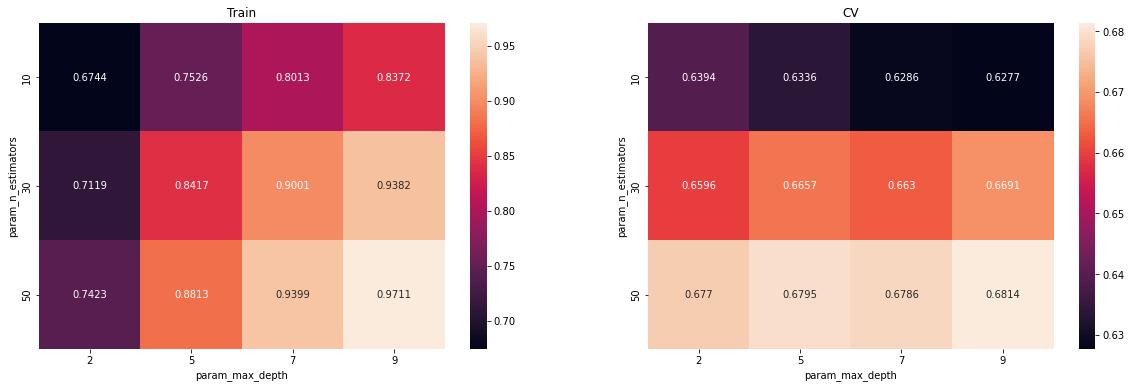

In [26]:
fig, ax = plt.subplots(1,2, figsize=(20,6))

sns.heatmap(pivoted_results.mean_train_score, annot = True, fmt='.4g',  ax = ax[0]) 
sns.heatmap(pivoted_results.mean_test_score,  annot = True, fmt='.4g',  ax = ax[1])

ax[0].set_title('Train')
ax[1].set_title('CV')

plt.show()

* Here we have white cells because we used randomizedsearchCV instead of gridsearch

In [27]:
print('Best ROC-AUC score: ',clf.best_score_)
print('Best Parameter are: ',clf.best_params_)

Best ROC-AUC score:  0.6813707442174115
Best Parameter are:  {'max_depth': 9, 'n_estimators': 50}


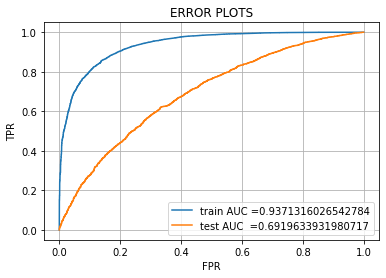

In [31]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc

gbdt = XGBClassifier(n_estimators = 50,max_depth = 9,subsample = 0.5,colsample_bytree = 0.5)
gbdt.fit(X_tr, y_train)

y_train_pred = gbdt.predict_proba(X_tr)[:,1]
y_test_pred  = gbdt.predict_proba(X_te)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr,  test_tpr, te_thresholds  = roc_curve(y_test,  y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr,   label="test AUC  ="+str(auc(test_fpr, test_tpr)))

plt.legend()

plt.xlabel("FPR")
plt.ylabel("TPR")

plt.title("ERROR PLOTS")

plt.grid()
plt.show()

* Here we can see clearly that our model is overfitting so we have to chose better hyperparameters to resolve the issue.

* let's start by fixing our max_depth = 5 , as we do not want very large depth trees in GBDT we need high biased models and we will try new hyperparameter called learning rate and see if that's work or not .

* here if learning rate increases then model overfits but if we reduce the learning rate then it increase both train and query time , and since here we want to avoid overfiting so we won't focus much on time part.

* https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

* https://www.kaggle.com/code/tilii7/hyperparameter-grid-search-with-xgboost/notebook


The above Best parameters resulted in overfitting of the model which was not desired Hence we will select the parameters on the basis of least difference between train and test ROC SCOre which is nothing but 

depth = 2, n_estimators = 10 would have been bettwe choice but before making anymore conclusion let's try out one more hyperparameter which is regularisation by shrinkage

In [33]:
%%time 
# around 1 min 45 sec  minutes

# we can also use bayesian optimization for xgboost if the hyperparameters increases  

from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

gbdt = XGBClassifier(max_depth = 3,random_state = 42,subsample = 0.5,colsample_bytree = 0.5)

grid_params = {'n_estimators': [10,30,50], 'learning_rate':[0.001, 0.01, 0.1,1.0]}
 
clf = GridSearchCV(gbdt,grid_params ,cv = 2, scoring = 'roc_auc',n_jobs =-1,verbose = 3,return_train_score =  True)
clf.fit(X_tr, y_train)  

results = pd.DataFrame.from_dict(clf.cv_results_)

results.head(3)

Fitting 2 folds for each of 12 candidates, totalling 24 fits
CPU times: user 10.7 s, sys: 225 ms, total: 11 s
Wall time: 1min 45s


In [34]:
results.head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_n_estimators,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,mean_train_score,std_train_score
0,4.636548,0.071819,1.322032,0.013726,0.001,10,"{'learning_rate': 0.001, 'n_estimators': 10}",0.621970,0.638858,0.630414,0.008444,9,0.681035,0.679624,0.680330,0.000705
1,5.421792,0.002308,1.015029,0.011987,0.001,30,"{'learning_rate': 0.001, 'n_estimators': 30}",0.631942,0.664844,0.648393,0.016451,6,0.704088,0.725678,0.714883,0.010795
2,8.253812,0.059713,1.056866,0.011934,0.001,50,"{'learning_rate': 0.001, 'n_estimators': 50}",0.635862,0.668618,0.652240,0.016378,4,0.714516,0.735462,0.724989,0.010473


In [35]:
pivoted_results = results.pivot(index = 'param_n_estimators', columns = 'param_learning_rate')

pivoted_results.head()

mean_fit_time                               std_fit_time  \
param_learning_rate         0.001     0.010     0.100     1.000        0.001   
param_n_estimators                                                             
10                       4.636548  2.619750  2.567343  2.640408     0.071819   
30                       5.421792  5.540885  5.349922  5.548044     0.002308   
50                       8.253812  8.133899  8.393889  8.200378     0.059713   

                                                  mean_score_time            \
param_learning_rate     0.010     0.100     1.000           0.001     0.010   
param_n_estimators                                                            
10                   0.003480  0.003998  0.013693        1.322032  0.998640   
30                   0.003990  0.008715  0.001200        1.015029  1.012828   
50                   0.006707  0.015707  0.034461        1.056866  1.022614   

                     ... split1_train_score           mean_train_score  \
param_learning_rate  ...              0.100     1.000            0.001   
param_n_estimators   ...                                                 
10                   ...           0.694951  0.708904         0.680330   
30                   ...           0.760649  0.789592         0.714883   
50                   ...           0.795765  0.833865         0.724989   

                                                  std_train_score            \
param_learning_rate     0.010     0.100     1.000           0.001     0.010   
param_n_estimators                                                            
10                   0.680460  0.694968  0.715388        0.000705  0.000813   
30                   0.719315  0.756272  0.787456        0.010795  0.010186   
50                   0.732049  0.793046  0.827680        0.010473  0.009373   

                                         
param_learning_rate     0.100     1.000  
param_n_estimators                       
10                   0.000017  0.006484  
30                   0.004377  0.002136  
50                   0.002719  0.006185  

[3 rows x 56 columns]

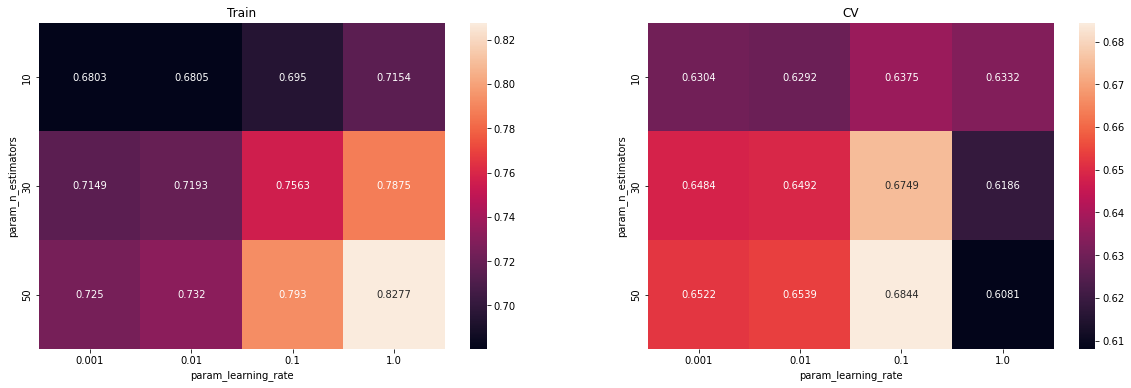

In [36]:
fig, ax = plt.subplots(1,2, figsize=(20,6))

sns.heatmap(pivoted_results.mean_train_score, annot = True, fmt='.4g',  ax = ax[0]) 
sns.heatmap(pivoted_results.mean_test_score,  annot = True, fmt='.4g',  ax = ax[1])

ax[0].set_title('Train')
ax[1].set_title('CV')

plt.show()

* here we can see that increasing the n_estimators also increasing the overfiting, so we will take minimum number of estimators which is giving the same performance on test data  


In [37]:
print('Best ROC-AUC score: ',clf.best_score_)
print('Best Parameter are: ',clf.best_params_)

Best ROC-AUC score:  0.684394712750062
Best Parameter are:  {'learning_rate': 0.1, 'n_estimators': 50}


But we will chose the hyperparameters that will give us the minumum difference of train and test ROC scores

Hence 
n_estimators  = 10

max_depth     = 2

learning_rate = 0.001

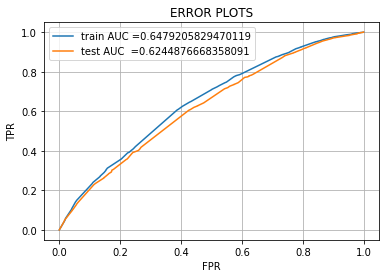

In [39]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc

gbdt = XGBClassifier(n_estimators = 10,max_depth = 2, learning_rate = 0.001,subsample = 0.5,colsample_bytree = 0.5)
gbdt.fit(X_tr, y_train)

y_train_pred = gbdt.predict_proba(X_tr)[:,1]
y_test_pred  = gbdt.predict_proba(X_te)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr,  test_tpr, te_thresholds  = roc_curve(y_test,  y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr,   label="test AUC  ="+str(auc(test_fpr, test_tpr)))

plt.legend()

plt.xlabel("FPR")
plt.ylabel("TPR")

plt.title("ERROR PLOTS")

plt.grid()
plt.show()

* we were able to reduce the overfiting significantly if we compare it with our previous models .

In [40]:
def find_best_threshold(threshold, fpr, tpr):
    t = threshold[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    
    return t

def predict_with_best_t(proba, threshold):
    predictions = []
    
    for i in proba:
        if i>= threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

from sklearn.metrics import confusion_matrix

best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)

the maximum value of tpr*(1-fpr) 0.3726400192128776 for threshold 0.503


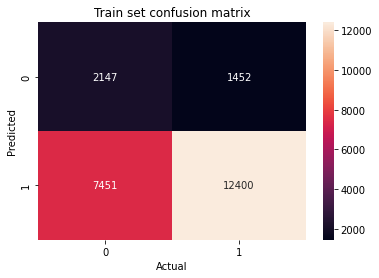

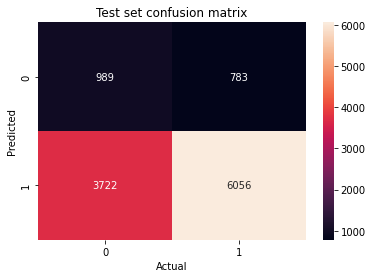

In [41]:
# Heatmap for train set confusion matrix()

heatmap_train = sns.heatmap(confusion_matrix(y_train, predict_with_best_t(y_train_pred,best_t)), annot = True, fmt = "d")

plt.title("Train set confusion matrix")

plt.xlabel("Actual")
plt.ylabel("Predicted")

plt.show()

# Heatmap for test set confusion matrix()

heatmap_test = sns.heatmap(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)), annot = True, fmt = "d")

plt.title("Test set confusion matrix")

plt.xlabel("Actual")
plt.ylabel("Predicted")

plt.show()

## Word2vec

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range = (1, 3),max_features = 6000, min_df = 10)

vectorizer.fit(X_train['essay'].values)

X_train_essay_tfidf = vectorizer.transform(X_train['essay'].values)
X_test_essay_tfidf  = vectorizer.transform(X_test['essay'].values)

# we are converting a dictionary with word as a key, and the idf as a value

dictionary  = dict(zip(vectorizer.get_feature_names(), list(vectorizer.idf_)))
tfidf_words = set(dictionary.keys())

In [43]:
with open('/content/drive/MyDrive/Case Studies/Donor Choose/9_Donors_choose_DT/glove_vectors', 'rb') as f:
    
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [44]:
# 4. perform tfidf w2v vectorization of text data.

tfidf_w2v_vectors = []; # the tf-idf weighted word2vec for each sentence/review is stored in this list

for sentence in tqdm(X_train['essay'].values): # for each review/sentence

    vector = np.zeros(300) # Initializing the vectors with all zeros 
    tf_idf_weight = 0; # num of words with a valid vector in the sentence/review

    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors.append(vector)

print(len(tfidf_w2v_vectors))
print(len(tfidf_w2v_vectors[0]))

tfidf_w2v_vectors = np.array(tfidf_w2v_vectors)

100%|██████████| 23450/23450 [01:02<00:00, 378.09it/s]

23450
300


In [45]:
tfidf_w2v_vectors_test = []; # the tf-idf weighted word2vec for each sentence/review is stored in this list

for sentence in tqdm(X_test['essay'].values): # for each review/sentence

    vector = np.zeros(300) # Initializing the vectors with all zeros 
    tf_idf_weight = 0; # num of words with a valid vector in the sentence/review

    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_test.append(vector)

print(len(tfidf_w2v_vectors_test))
print(len(tfidf_w2v_vectors_test[0]))

tfidf_w2v_vectors_test = np.array(tfidf_w2v_vectors_test)

100%|██████████| 11550/11550 [00:31<00:00, 362.12it/s]

11550
300


In [46]:
from scipy.sparse import  hstack

X_tr = hstack((
               tfidf_w2v_vectors,
               np.array(school_state_pos).reshape(-1,1),np.array(school_state_neg).reshape(-1,1),
               np.array(project_grade_pos).reshape(-1,1),np.array(project_grade_neg).reshape(-1,1),
               np.array(clean_subcategories_pos).reshape(-1,1),np.array(clean_subcategories_neg).reshape(-1,1),
               np.array(clean_categories_pos).reshape(-1,1),np.array(clean_categories_neg).reshape(-1,1),
               X_train_price_norm,X_train_projects_posted_norm,
               X_train['negative'].values.reshape(-1,1),
               X_train['neutral'].values.reshape(-1,1),
               X_train['positive'].values.reshape(-1,1),
               X_train['compound'].values.reshape(-1,1))).tocsr()

X_te = hstack((
               tfidf_w2v_vectors_test,
               np.array(school_state_pos_te).reshape(-1,1),np.array(school_state_neg_te).reshape(-1,1),
               np.array(project_grade_pos_te).reshape(-1,1),np.array(project_grade_neg_te).reshape(-1,1),
               np.array(clean_subcategories_pos_te).reshape(-1,1),np.array(clean_subcategories_neg_te).reshape(-1,1),
               np.array(clean_categories_pos_te).reshape(-1,1),np.array(clean_categories_neg_te).reshape(-1,1),
               X_test_price_norm,X_test_projects_posted_norm,
               X_test['negative'].values.reshape(-1,1),
               X_test['neutral'].values.reshape(-1,1),
               X_test['positive'].values.reshape(-1,1),
               X_test['compound'].values.reshape(-1,1))).tocsr()

print("Final Data matrix")

print(X_tr.shape, y_train.shape)
print(X_te.shape, y_test.shape)

ValueError: ignored

* the problem is that hstack should contain  atleast one sparse array 

https://stackoverflow.com/questions/55756294/scipy-sparse-hstack-valueerror-blocks-must-be-2-d

* use coo matrix,COO is a fast format for constructing sparse matrices

https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.coo_matrix.html

In [47]:
from scipy.sparse import coo_matrix

X_tr = hstack((
               coo_matrix(tfidf_w2v_vectors),
               np.array(school_state_pos).reshape(-1,1),np.array(school_state_neg).reshape(-1,1),
               np.array(project_grade_pos).reshape(-1,1),np.array(project_grade_neg).reshape(-1,1),
               np.array(clean_subcategories_pos).reshape(-1,1),np.array(clean_subcategories_neg).reshape(-1,1),
               np.array(clean_categories_pos).reshape(-1,1),np.array(clean_categories_neg).reshape(-1,1),
               X_train_price_norm,X_train_projects_posted_norm,
               X_train['negative'].values.reshape(-1,1),
               X_train['neutral'].values.reshape(-1,1),
               X_train['positive'].values.reshape(-1,1),
               X_train['compound'].values.reshape(-1,1))).tocsr()

X_te = hstack((
               coo_matrix(tfidf_w2v_vectors_test),
               np.array(school_state_pos_te).reshape(-1,1),np.array(school_state_neg_te).reshape(-1,1),
               np.array(project_grade_pos_te).reshape(-1,1),np.array(project_grade_neg_te).reshape(-1,1),
               np.array(clean_subcategories_pos_te).reshape(-1,1),np.array(clean_subcategories_neg_te).reshape(-1,1),
               np.array(clean_categories_pos_te).reshape(-1,1),np.array(clean_categories_neg_te).reshape(-1,1),
               X_test_price_norm,X_test_projects_posted_norm,
               X_test['negative'].values.reshape(-1,1),
               X_test['neutral'].values.reshape(-1,1),
               X_test['positive'].values.reshape(-1,1),
               X_test['compound'].values.reshape(-1,1))).tocsr()

print("Final Data matrix")

print(X_tr.shape, y_train.shape)
print(X_te.shape, y_test.shape)

Final Data matrix
(23450, 314) (23450,)
(11550, 314) (11550,)


Fitting 2 folds for each of 12 candidates, totalling 24 fits


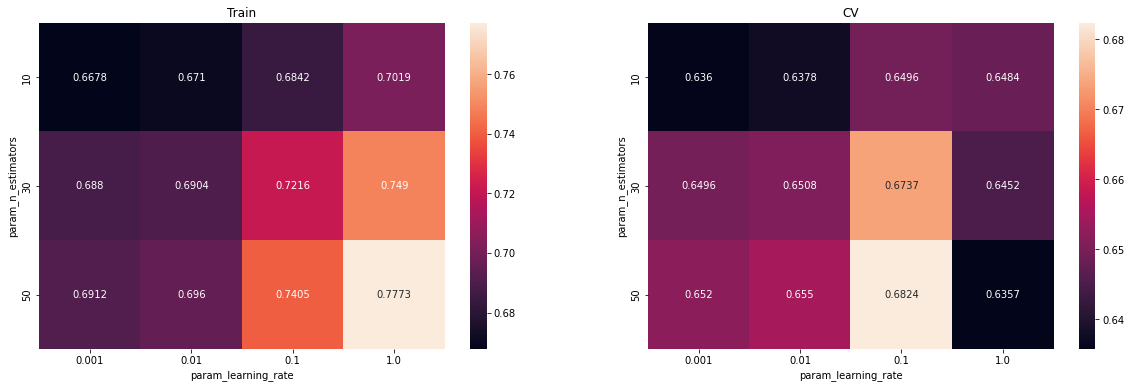

CPU times: user 11.2 s, sys: 505 ms, total: 11.7 s
Wall time: 2min 25s


In [50]:
%%time 
# it will take around 5min 37s 

from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

gbdt = XGBClassifier(max_depth = 2, colsample_bytree = 0.5,subsample = 0.5)

grid_params = {'n_estimators': [10,30,50], 'learning_rate' : [0.001, 0.01, 0.1, 1.0] }
 
clf = GridSearchCV(gbdt,grid_params ,cv = 2, scoring = 'roc_auc',n_jobs =-1,verbose = 2,return_train_score =  True)
clf.fit(X_tr, y_train)  

results = pd.DataFrame.from_dict(clf.cv_results_)

results.head(3)

pivoted_results = results.pivot(index = 'param_n_estimators', columns = 'param_learning_rate')

# pivoted_results.head()

fig, ax = plt.subplots(1,2, figsize=(20,6))

sns.heatmap(pivoted_results.mean_train_score, annot = True, fmt='.4g',  ax = ax[0]) 
sns.heatmap(pivoted_results.mean_test_score,  annot = True, fmt='.4g',  ax = ax[1])

ax[0].set_title('Train')
ax[1].set_title('CV')

plt.show()

In [ ]:
print('Best ROC-AUC score according to GridSearchCv: ',clf.best_score_)
print('Best Parameter according to GridSearchCv are: ',clf.best_params_)

Best ROC-AUC score:  0.6914018287248757
Best Parameter are:  {'learning_rate': 0.1, 'n_estimators': 100}


But looking at HeatMap it is clear that best hyperparameter should be 

n_estimators = 10

max_depth = 2

learning_rate = 0.001

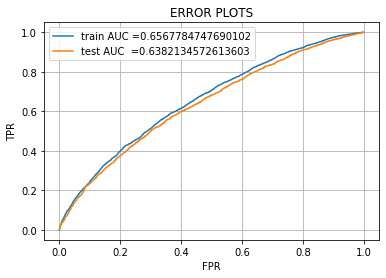

In [51]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc

gbdt = XGBClassifier(n_estimators = 10,max_depth = 2, colsample_bytree = 0.5,subsample = 0.5,learning_rate = 0.001)
gbdt.fit(X_tr, y_train)

y_train_pred = gbdt.predict_proba(X_tr)[:,1]
y_test_pred  = gbdt.predict_proba(X_te)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr,  test_tpr, te_thresholds  = roc_curve(y_test,  y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr,   label="test AUC  ="+str(auc(test_fpr, test_tpr)))

plt.legend()

plt.xlabel("FPR")
plt.ylabel("TPR")

plt.title("ERROR PLOTS")

plt.grid()
plt.show()

In [52]:
def find_best_threshold(threshold, fpr, tpr):
    t = threshold[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    
    return t

def predict_with_best_t(proba, threshold):
    predictions = []
    
    for i in proba:
        if i>= threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

from sklearn.metrics import confusion_matrix

best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)

the maximum value of tpr*(1-fpr) 0.3747067920525839 for threshold 0.503


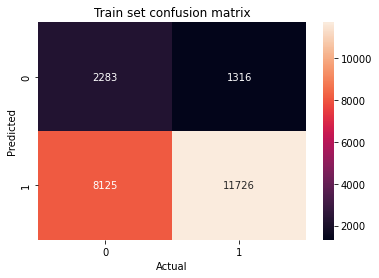

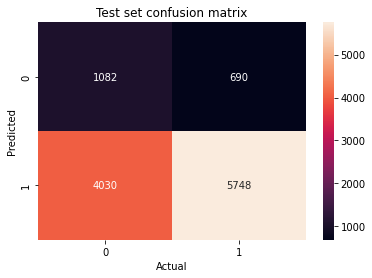

In [53]:
# Heatmap for train set confusion matrix()

heatmap_train = sns.heatmap(confusion_matrix(y_train, predict_with_best_t(y_train_pred,best_t)), annot = True, fmt = "d")

plt.title("Train set confusion matrix")

plt.xlabel("Actual")
plt.ylabel("Predicted")

plt.show()

# Heatmap for test set confusion matrix()

heatmap_test = sns.heatmap(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)), annot = True, fmt = "d")

plt.title("Test set confusion matrix")

plt.xlabel("Actual")
plt.ylabel("Predicted")

plt.show()

<h1>3. Summary</h1>

<br> as mentioned in the step 4 of instructions

In [54]:
from prettytable import PrettyTable
    
x = PrettyTable()
x.field_names = ["Vectorizer", "Model","Max Depth", "n_estimators","Learning Rate", "Train-AUC",'Test-AUC']

x.add_row(["TF-IDf", "XGBOOST",2, 10,'0.001', 0.64,0.62])

x.add_row(["TF-IDF weighted word2vec", "XGBOOST",  2, 10,'0.001', 0.65,0.63])

print(x)

+--------------------------+---------+-----------+--------------+---------------+-----------+----------+
|        Vectorizer        |  Model  | Max Depth | n_estimators | Learning Rate | Train-AUC | Test-AUC |
+--------------------------+---------+-----------+--------------+---------------+-----------+----------+
|          TF-IDf          | XGBOOST |     2     |      10      |     0.001     |    0.64   |   0.62   |
| TF-IDF weighted word2vec | XGBOOST |     2     |      10      |     0.001     |    0.65   |   0.63   |
+--------------------------+---------+-----------+--------------+---------------+-----------+----------+
